# Timeseries forecasting
Very simple example of trying to forecast a timeseries of electrical consuption at a plant. Data is from: https://github.com/zhouhaoyi/ETDataset/tree/main

Datasets are from two powerplants.
- Datasets m1, m2 are taken at minute level
- Datasets h1, h2 are taken at hour level

Description of the content: Each data point consists of 8 features, including the date of the point, the predictive value "oil temperature", and 6 different types of external power load features.

The target is the oil temperature (OT).

In [50]:
import pandas as pd 

df = pd.read_csv("../data/ETT-small/ETTm1.csv")
print(f"{df.columns}, {df.size}")

Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object'), 557440


# Multivariate
For multivariate, we want to use the correlation of the parallel time series in order to facilitate the prediction of the target. We need to concatenate the values of each timestep as a vector. We will then have a vector of size (timesteps * num_predictor)

In [51]:
data= df.drop("date", axis="columns").to_numpy()
target = df['OT'].to_numpy()
print(f"Data shape: {data.shape}, target shape: {target.shape}")
print(data[0])

Data shape: (69680, 7), target shape: (69680,)
[ 5.82700014  2.00900006  1.59899998  0.46200001  4.20300007  1.34000003
 30.53100014]


In [52]:
import matplotlib.pyplot as plt

def visualize_ts(fig_name, ts, ts_name):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(ts, label=ts_name)

    # Adding a plot title and customizing its font size
    plt.title(fig_name)

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

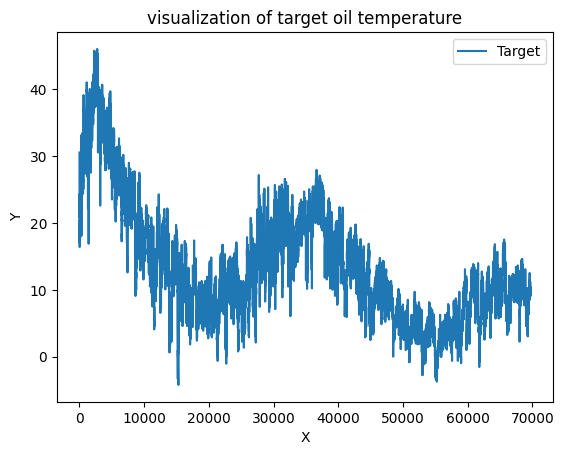

In [53]:
visualize_ts("visualization of target oil temperature", target, "Target")

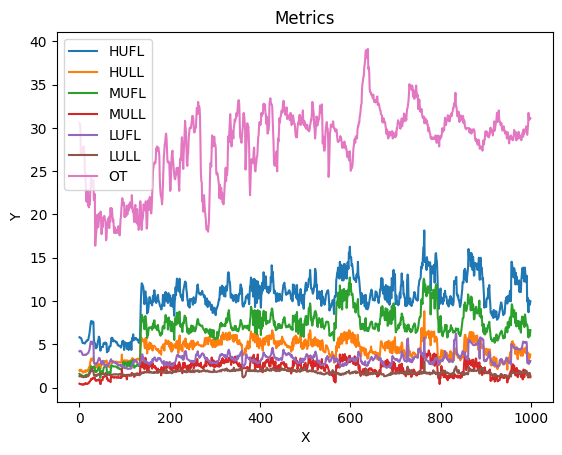

In [54]:
import matplotlib.pyplot as plt

def visualize_metrics(data, col_names):
    # Adjusting the figure size
    fig = plt.figure()

    for i in range(len(col_names)):
        plt.plot(data[:, i], label=col_names[i])

    # Adding a plot title and customizing its font size
    plt.title("Metrics")

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

col_names = df.columns[1:]
visualize_metrics(data[:1000], col_names)

# Model building
A very simple LSTM model

In [55]:
import torch
import torch.nn as nn

class LstmForecaster(nn.Module):
    lstm_layer: nn.LSTM
    output_linear_layers: nn.Sequential

    def __init__(self, input_size, hidden_size, num_layers, output_size, is_bidirectional):
        super().__init__()
        self.lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=is_bidirectional)
        output_linear_layer_in = hidden_size*2 if is_bidirectional else hidden_size
        self.output_linear_layer = nn.Linear(output_linear_layer_in, output_size)

    def forward(self, x):
        #Pass through LSTM (L,N,Hin​)
        x, _ = self.lstm_layer(x)
        
        #Return linear layer prediction for next value based on the last very last hidden output of every batched input
        x = self.output_linear_layer(x[:, -1, :])
        
        return x

# Data preparation
Prepare data: Prepare trajectories for the forecasting task and put then in pytorch dataloards

Shape of X data: torch.Size([69440, 180, 7])
Shape of y data: torch.Size([69440, 60, 1])
Shape of train dataset: torch.Size([55552, 180, 7])
Shape of test dataset: torch.Size([13888, 180, 7])


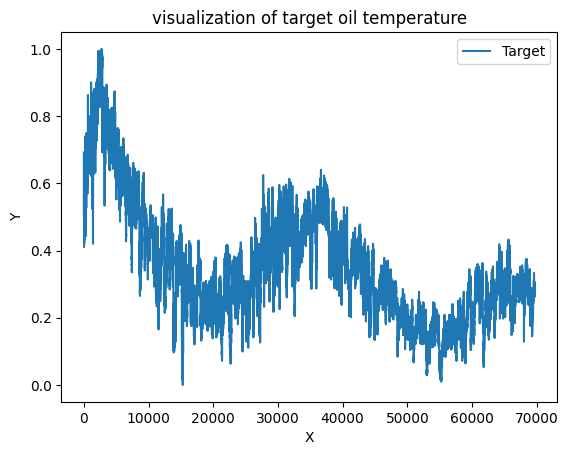

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Task Constants
LOOKBACK= 180
FORECAST_SIZE = 60
number_of_metrics = data.shape[1]

#Apply scalign to the whole dataset before creating the trajectories
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, number_of_metrics))
target_scaled = data_scaled[:,-1]

#Create trajectories
X, y = [], []
for i in range(0, len(target_scaled) - LOOKBACK - FORECAST_SIZE):
    X.append(data_scaled[i:i+LOOKBACK])
    y.append(target_scaled[i+LOOKBACK:i+LOOKBACK+FORECAST_SIZE])

X, y = torch.FloatTensor(np.asarray(X)), torch.FloatTensor(np.asarray(y)).unsqueeze(-1)

print(f"Shape of X data: {X.shape}")
print(f"Shape of y data: {y.shape}")

test_size = 0.2  # Adjust the test set size as needed
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print(f"Shape of train dataset: {X_train.shape}")
print(f"Shape of test dataset: {X_test.shape}")

class SimpleDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

batch_size = 32
shuffle = False

train_dataset = SimpleDataset(X_train, Y_train)
test_dataset = SimpleDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

visualize_ts("visualization of target oil temperature", target_scaled, "Target")

# Prepare visualization function of predicted / actual 

In [57]:
import matplotlib.pyplot as plt

def plot_forecast(predicted_ts, expected_ts, lookback_size):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(predicted_ts, label="Predicted values", color="g")
    plt.plot(expected_ts, label="Expected values", color="b")

    # Adding a plot title and customizing its font size
    plt.title("Forecasting outcomes")
    plt.axvline(lookback_size-1, 0, 1, linestyle="dashed")

    # Adding axis labels and customizing their font size
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.legend()
    plt.show()

# Train model

In [59]:
import numpy as np

# Model-related constants
INPUT_SIZE = number_of_metrics
HIDDEN_SIZE = 50
NUM_LAYERS = 2

model = LstmForecaster(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, FORECAST_SIZE, True)

#Loop-related
num_epochs = 20

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
  print(f"Epoch {epoch}...", end="")

  batch_train_losses = []
  for X_train, y_train in train_dataloader:
    y_pred = model(X_train).unsqueeze(-1)

    loss = loss_fn(y_pred, y_train)
    batch_train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  epoch_training_loss = np.mean(batch_train_losses)
  train_losses.append(epoch_training_loss)
  print(f"Mean training loss: {epoch_training_loss}")

  with torch.no_grad():
    test_batch_losses = []

    for X_test, y_test in test_dataloader:
      test_pred = model(X_test).unsqueeze(-1)

      loss = loss_fn(test_pred, y_test)
      test_batch_losses.append(loss.item())
    
    epoch_test_loss = np.mean(test_batch_losses)
    test_losses.append(epoch_test_loss)
    print(f'Test Loss: {epoch_test_loss:.4f}')


Epoch 0...Mean training loss: 0.003744696133333089
Test Loss: 0.0018
Epoch 1...Mean training loss: 0.0017798660427100167
Test Loss: 0.0016
Epoch 2...Mean training loss: 0.0016287200522103694
Test Loss: 0.0015
Epoch 3...Mean training loss: 0.0015902084444018086
Test Loss: 0.0016
Epoch 4...Mean training loss: 0.001542987280184873
Test Loss: 0.0015
Epoch 5...Mean training loss: 0.001515474940155534
Test Loss: 0.0015
Epoch 6...Mean training loss: 0.0014813443715107405
Test Loss: 0.0014
Epoch 7...Mean training loss: 0.001452892705118702
Test Loss: 0.0014
Epoch 8...Mean training loss: 0.001426511695188704
Test Loss: 0.0014
Epoch 9...Mean training loss: 0.0013901100514487745
Test Loss: 0.0014
Epoch 10...Mean training loss: 0.001372342365273502
Test Loss: 0.0013
Epoch 11...Mean training loss: 0.0013638060205803286
Test Loss: 0.0013
Epoch 12...Mean training loss: 0.0013357885783427709
Test Loss: 0.0013
Epoch 13...Mean training loss: 0.0013087296895715
Test Loss: 0.0013
Epoch 14...Mean training 

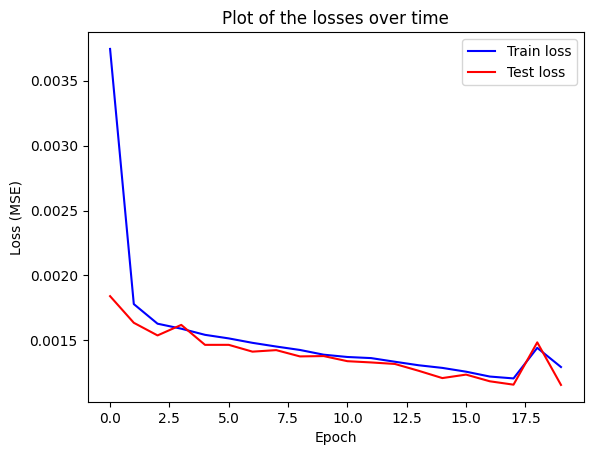

In [60]:
def plot_losses(train_loss, test_loss):
    # Adjusting the figure size
    fig = plt.figure()

    # Creating a plot
    plt.plot(train_loss, label="Train loss", color="b")
    plt.plot(test_loss, label="Test loss", color="r")

    # Adding a plot title and customizing its font size
    plt.title("Plot of the losses over time")

    # Adding axis labels and customizing their font size
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')

    plt.legend()
    plt.show()

plot_losses(train_losses, test_losses)

# Output some predictions

Sampling 180 data from ID 14455
Generating forecast of length 60
torch.Size([1, 60])


/tmp/ipykernel_994/2804076184.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(X.reshape(1, lookback, INPUT_SIZE)).float()


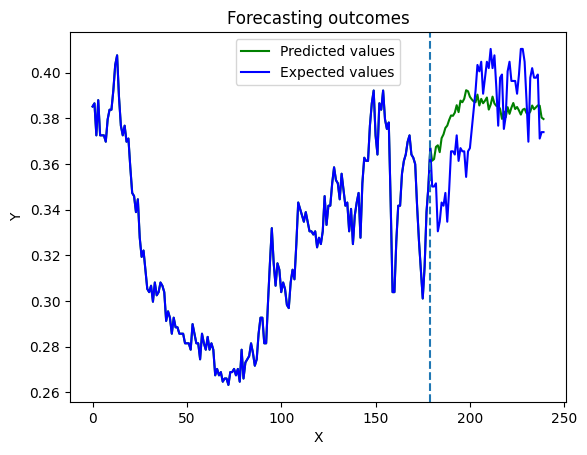

In [69]:
def make_prediction(model, X, lookback):
    """ forecast_metrics is the forecast of shape (metrics-1) that tells us the metric values at timestap t+1..t+forecast as we only
    expect to predict the target and assume we have values for the metric in that time"""
    #Prepare a random dataset sample

    with torch.no_grad():
        input_tensor = torch.tensor(X.reshape(1, lookback, INPUT_SIZE)).float()
        pred = model(input_tensor)
        print(pred.shape)

        return pred[0]

# target_np is the timeseries as a simple numpy ndarray
idx = np.random.randint(0, len(target) - (LOOKBACK + FORECAST_SIZE) - 1)
print(f"Sampling {LOOKBACK} data from ID {idx}")
lookback = torch.tensor(data_scaled[idx:idx+LOOKBACK, :])

groundtruth_forecast = target_scaled[idx+LOOKBACK : idx+LOOKBACK+FORECAST_SIZE]

print(f"Generating forecast of length {FORECAST_SIZE}")
y_predicted = make_prediction(model, lookback, LOOKBACK)


plot_forecast(lookback[:, -1].reshape(LOOKBACK).tolist() + y_predicted.tolist(), 
              lookback[:, -1].reshape(LOOKBACK).tolist() + groundtruth_forecast.tolist(), 
              LOOKBACK)

# Perform a rolling evaluation of the timeseries to check the X+1 forecasting capability

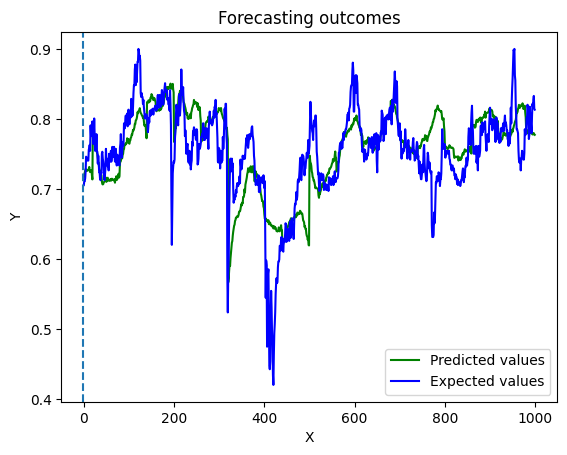

In [71]:
# Predictions are shifted of the lookback data
predictions = [0] * LOOKBACK

with torch.no_grad():
    for i in range(0, data_scaled.shape[0] - LOOKBACK - FORECAST_SIZE, FORECAST_SIZE):
        input_data = data_scaled[i:i+LOOKBACK, :].reshape(1, LOOKBACK, INPUT_SIZE)

        input_tensor = torch.tensor(input_data).float()
        pred = model(input_tensor)
        predictions.extend(pred[0].tolist())

plot_forecast(predictions[1000:2000], target_scaled[1000:2000], 0)
